In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model 
import keras
from mpl_toolkits.mplot3d import Axes3D
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 8s 1us/step


In [6]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
classes = len(np.unique(train_labels))
classes

10

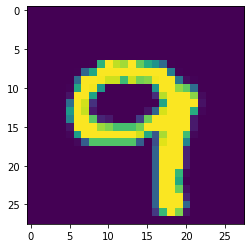

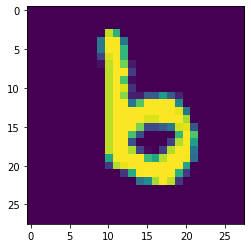

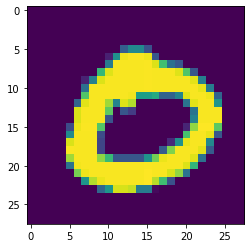

In [8]:
for _ in range(3):
    N = np.random.randint(0, test_images.shape[0], 1)[0]
    plt.imshow(test_images[N])
    plt.show()

### Types of data augumentation for further usage

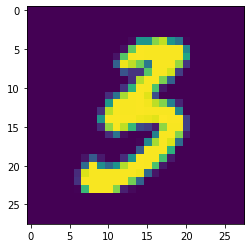

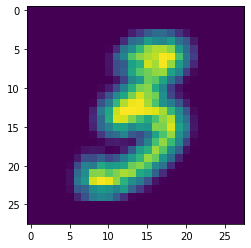

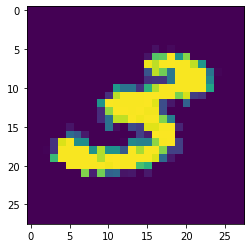

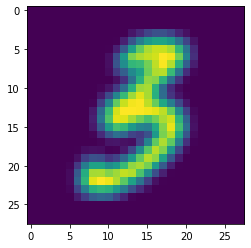

In [6]:
N = np.random.randint(0, test_images.shape[0], 1)[0]
plt.imshow(test_images[N])
plt.show()
plt.imshow(tfa.image.sharpness(test_images[N], -1))
plt.show()
plt.imshow(tfa.image.rotate(test_images[N], -0.5))
plt.show()
plt.imshow(tfa.image.mean_filter2d(test_images[N]))
plt.show()

In [10]:
train_lbl = to_categorical(train_labels, classes)
test_lbl = to_categorical(test_labels,classes)
train_img = train_images.astype('float32')
test_img = test_images.astype('float32')
train_img /= np.max(np.append(train_img, test_img))
test_img /= np.max(np.append(train_img, test_img))

In [13]:
flatten_size = train_img.shape[1] * train_img.shape[2]
train_img = train_img.reshape((-1, flatten_size))
test_img = test_img.reshape((-1, flatten_size))

### Baseline with hyperparameters tunning

In [10]:
optimizers = ['adam', 'SGD', 'RMSprop']
neuron_layers = [2, 3, 5, 7, 10]
neurons_amount = [32, 64, 128, 256, 512]

result = pd.DataFrame(columns=['Optimizer',
                               'Neuron_layers',
                               'Neurons_per_layer',
                               'Train_accuracy',
                               'Valid_accuracy',
                               'Test_accuracy',
                              ])

# Задаем вариации гиперпараметров
for optim in optimizers:
    for layers in neuron_layers:
        for neurons in neurons_amount:
            
            iter_metrics = []
            for i in range(1):
                model = Sequential()
                for k in range(layers-1):
                    model.add(Dense(neurons, activation='relu', input_shape=(flatten_size,)))  
                    
                model.add(Dense(classes, activation='softmax'))
                model.compile(optimizer=optim,
                              loss='categorical_crossentropy',
                              metrics=['accuracy']) 
                history = model.fit(train_img,
                                    train_lbl,
                                    epochs=15,
                                    batch_size=32,
                                    validation_split=0.2,
                                    verbose=0)
                
                test_metrics = model.evaluate(test_img,
                                              test_lbl)
        
                iter_metrics.append([history.history['accuracy'][-1],
                                    history.history['val_accuracy'][-1],
                                    test_metrics[1]])
            
            iter_metrics = np.array(iter_metrics)      
            result.loc[len(result)] = [optim,
                                       layers, 
                                       neurons,
                                       iter_metrics[:,0].mean(),
                                       iter_metrics[:,1].mean(),
                                       test_metrics[1]]

313/313 [==============================] - 1s 4ms/step - loss: 2.3011 - accuracy: 0.1135


In [11]:
# The best hyperparameters
result.loc[result['Test_accuracy']==result['Test_accuracy'].max(), :]

,Optimizer,Neuron_layers,Neurons_per_layer,Train_accuracy,Valid_accuracy,Test_accuracy
13,adam,5,256,0.993771,0.980333,0.9815


### Let's analyse surfaces of hypeprarameters and metrics

In [14]:
result[['Neuron_layers', 'Neurons_per_layer']] = result[['Neuron_layers', 'Neurons_per_layer']].astype('int32')

Text(0.5, 0, 'Accuracy')

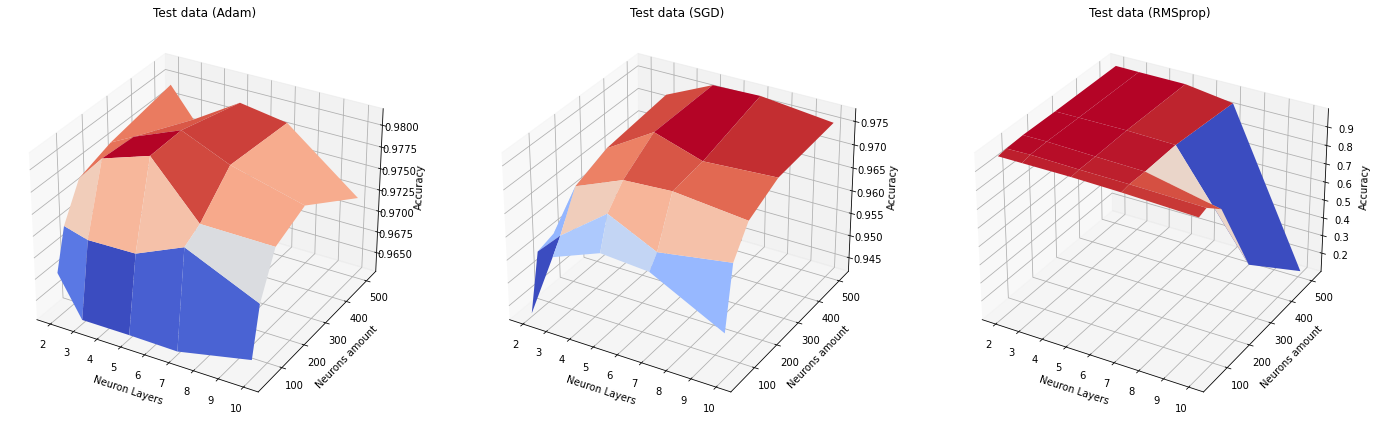

In [15]:
fig = plt.figure(figsize=(24, 8))

x = np.reshape(result.loc[result['Optimizer']=='adam', ['Neuron_layers']].values, (-1, 5))
y = np.reshape(result.loc[result['Optimizer']=='adam', ['Neurons_per_layer']].values, (-1, 5))
z_test = np.reshape(result.loc[result['Optimizer']=='adam', ['Test_accuracy']].values, (-1, 5))
ax = fig.add_subplot(131, projection='3d', title='Test data (Adam)')
ax.plot_surface(x, y, z_test, cmap='coolwarm')
ax.set_xlabel('Neuron Layers')
ax.set_ylabel('Neurons amount')
ax.set_zlabel('Accuracy')

x = np.reshape(result.loc[result['Optimizer']=='SGD', ['Neuron_layers']].values, (-1, 5))
y = np.reshape(result.loc[result['Optimizer']=='SGD', ['Neurons_per_layer']].values, (-1, 5))
z_test = np.reshape(result.loc[result['Optimizer']=='SGD', ['Test_accuracy']].values, (-1, 5))
ax = fig.add_subplot(132, projection='3d', title='Test data (SGD)')
ax.plot_surface(x, y, z_test, cmap='coolwarm')
ax.set_xlabel('Neuron Layers')
ax.set_ylabel('Neurons amount')
ax.set_zlabel('Accuracy')

x = np.reshape(result.loc[result['Optimizer']=='RMSprop', ['Neuron_layers']].values, (-1, 5))
y = np.reshape(result.loc[result['Optimizer']=='RMSprop', ['Neurons_per_layer']].values, (-1, 5))
z_test = np.reshape(result.loc[result['Optimizer']=='RMSprop', ['Test_accuracy']].values, (-1, 5))
ax = fig.add_subplot(133, projection='3d', title='Test data (RMSprop)')
ax.plot_surface(x, y, z_test, cmap='coolwarm')
ax.set_xlabel('Neuron Layers')
ax.set_ylabel('Neurons amount')
ax.set_zlabel('Accuracy')

### Let's apply augumentation and train the model with the best hyperparameters

In [74]:
new_train_img = train_images.copy()
new_train_lbl = train_labels.copy()

for angle in np.arange(-0.2, 0.21, 0.4):
    _new_train_img = []
    for i in range(train_images.shape[0]):
        _new_train_img.append(tfa.image.rotate(train_images[i], angle))
    new_train_img = tf.concat([new_train_img, _new_train_img], axis=0)
    new_train_lbl = tf.concat([new_train_lbl, train_labels], axis=0)
    
for sharp in np.arange(-2, 2.1, 4):
    _new_train_img = []
    for i in range(train_images.shape[0]):
        _new_train_img.append(tfa.image.sharpness(train_images[i], int(sharp)))
    new_train_img = tf.concat([new_train_img, _new_train_img], axis=0)
    new_train_lbl = tf.concat([new_train_lbl, train_labels], axis=0)
                              
new_train_img.shape, new_train_lbl.shape                    

(TensorShape([300000, 28, 28]), TensorShape([300000]))

In [75]:
train_lbl = to_categorical(new_train_lbl, classes)
test_lbl = to_categorical(test_labels, classes)
train_img = new_train_img.numpy() / np.max(np.append(new_train_img.numpy(), test_images))
test_img = test_images / np.max(np.append(new_train_img.numpy(), test_images))

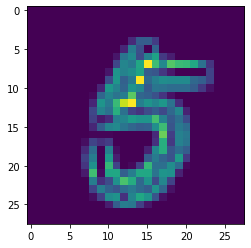

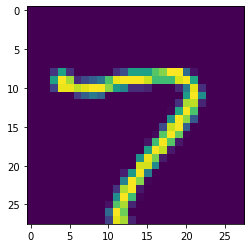

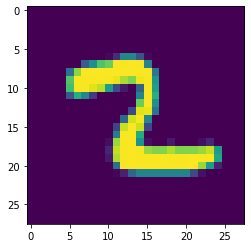

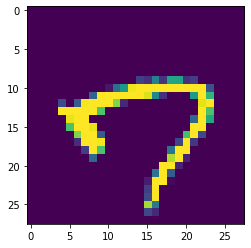

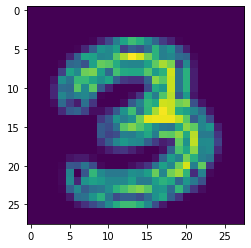

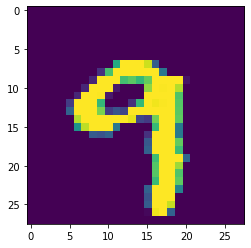

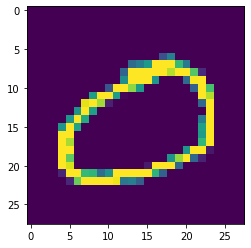

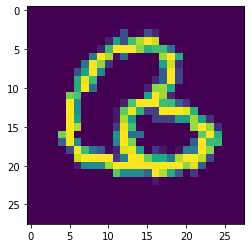

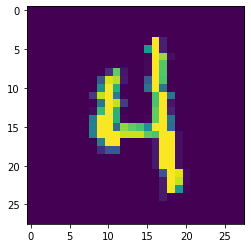

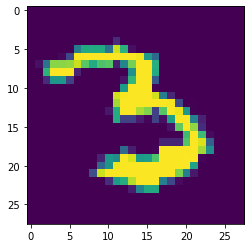

In [77]:
for _ in range(10):
    N = np.random.randint(0, new_train_img.shape[0], 1)[0]
    plt.imshow(new_train_img[N])
    plt.show()

In [78]:
flatten_size = train_img.shape[1] * train_img.shape[2]
train_img = train_img.reshape((-1, flatten_size))
test_img = test_img.reshape((-1, flatten_size))

In [79]:
model_best = Sequential(name='best_mnist_model')
for i in range(5):
    model_best.add(Dense(256, activation='relu', input_shape=(flatten_size,)))  
model_best.add(Dense(classes, activation='softmax')) 

model_best.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
) 

In [81]:
history = model_best.fit(train_img,
                         train_lbl,
                         epochs=50,
                         batch_size=32,
                         validation_split=0.2,
                         verbose=1)

test_metrics = model_best.evaluate(test_img,
                                   test_lbl)

Epoch 1/20
7500/7500 [==============================] - 20s 3ms/step - loss: 0.0159 - accuracy: 0.9963 - val_loss: 0.0131 - val_accuracy: 0.9973
Epoch 2/20
7500/7500 [==============================] - 20s 3ms/step - loss: 0.0187 - accuracy: 0.9966 - val_loss: 0.0171 - val_accuracy: 0.9959
Epoch 3/20
7500/7500 [==============================] - 20s 3ms/step - loss: 0.0150 - accuracy: 0.9968 - val_loss: 0.0091 - val_accuracy: 0.9980
Epoch 4/20
7500/7500 [==============================] - 20s 3ms/step - loss: 0.0139 - accuracy: 0.9968 - val_loss: 0.0112 - val_accuracy: 0.9986
Epoch 5/20
7500/7500 [==============================] - 21s 3ms/step - loss: 0.0157 - accuracy: 0.9966 - val_loss: 0.0064 - val_accuracy: 0.9984
Epoch 6/20
7500/7500 [==============================] - 20s 3ms/step - loss: 0.0140 - accuracy: 0.9971 - val_loss: 0.0156 - val_accuracy: 0.9965
Epoch 7/20
7500/7500 [==============================] - 21s 3ms/step - loss: 0.0139 - accuracy: 0.9972 - val_loss: 0.0092 - val_ac

### Model accuracy has been increased especcially on validation data (data augumentation is a some kind of regularization). Let's check confusion matrix.

In [138]:
test_img.shape, test_labels.shape

((10000, 784), (10000,))

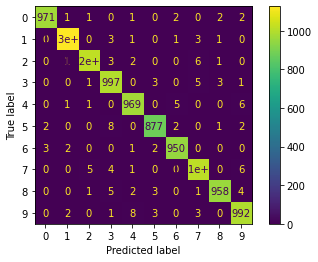

In [82]:
y_pred = np.argmax(model_best.predict(test_img), axis=1)
cm = confusion_matrix(test_labels,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot( values_format ='.3g')
plt.show()

### Quite well, let's make prediction and send result

In [86]:
train_file = pd.read_csv('train.csv')
test_file = pd.read_csv('test.csv')

In [89]:
train_file.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
labels = train_file["label"].values
features = train_file.drop(labels = ["label"], axis = 1).to_numpy()

In [140]:
features = features / np.max(features)
labels = to_categorical(labels, classes)

In [141]:
features.shape, labels.shape

((42000, 784), (42000, 10))

In [142]:
model_best.evaluate(features, labels)

1313/1313 [==============================] - 2s 2ms/step - loss: 0.0386 - accuracy: 0.9974


[0.038643576204776764, 0.9973809719085693]

In [146]:
test_file.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
test = test_file.to_numpy()
test = test / np.max(test)

In [147]:
prediction = np.argmax(model_best.predict(test), axis=1)

In [164]:
pd.DataFrame(data=list(zip(test_file.index.values + 1, prediction)), columns=['ImageId', 'Label']).head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [163]:
pd.DataFrame(data=list(zip(test_file.index.values + 1, prediction)), columns=['ImageId', 'Label']).to_csv('MNIST_prediction.csv', index=False)